# Testing out music generator

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [4]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [5]:
os.environ['QT_QPA_PLATFORM']='offscreen'
os.environ['QT_QPA_FONTDIR']='/usr/share/fonts'

### Load data
Data has already been encoded to text format in previous notebooks.

In [5]:
path = Path('data/midi/v7/midi_encode/text/shortdur/')

In [6]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=8, bptt=500)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())

In [7]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

266

In [8]:
# Here's what it looks like
t = data.train_ds[0][0]
t.text[:100], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t0 nF3 t1 || t0 nE3 t1 || t0 nA2 t1 || t0 nF3 t1 ||',
 array([ 2,  9,  8, 21, ..., 40, 26, 36, 26]))

### Load model

In [9]:
get_files(path/'models/fastai/txl', recurse=True)
model_path = 'fastai/txl/hook/1_ep80_run1_best'

In [10]:
tfmerXL_lm_config['mem_len'] = 1024
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:215: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [11]:
learn = learn.load(model_path, strict=False)

## Create seed 
Grab a few notes/sequences from an existing song to create a seed. This seed will give our model an idea to build upon

Modify `seed_len` so that the model sees just enough of the song to get an idea.

In [12]:
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)

### Option 1: Generate seed from a random file

In [13]:
file = np.random.choice(files); file

PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/z/zun/the-shining-needle-castle-sinking-in-the-air/pre-chorus_key.txt')

### Option 2: Search for a song and generate seed from that

In [14]:
# Loading from specific file
keywords = ['avicii', 'waiting']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/verse_key.txt'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/intro_key.txt'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/chorus_key.txt')]

In [15]:
file = search[1]; file

PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/intro_key.txt')

### Listen/view seed

In [16]:
with open(file, 'r') as f: txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); 
seed_stream = str2stream(seed)

len(notes), seed

(120,
 '|| t0 nF#2 t6 nA2 t6 nC#3 t6 nF#5 t4 || t3 nF#5 t4 || t1 nF#2 t2 nA2 t2 nC#3 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t4 || t3 nF#5 t4 || t1 nC#3 t2 nF3 t2 nG#3 t2 || t1 nD3 t16 nF#3 t16 nA3 t16 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t4 || t3 nD3 t8 nF#3 t8 nA3 t8 nF#5 t6 || t5 nE5 t2')

In [17]:
# Sound
seed_stream.show('midi')

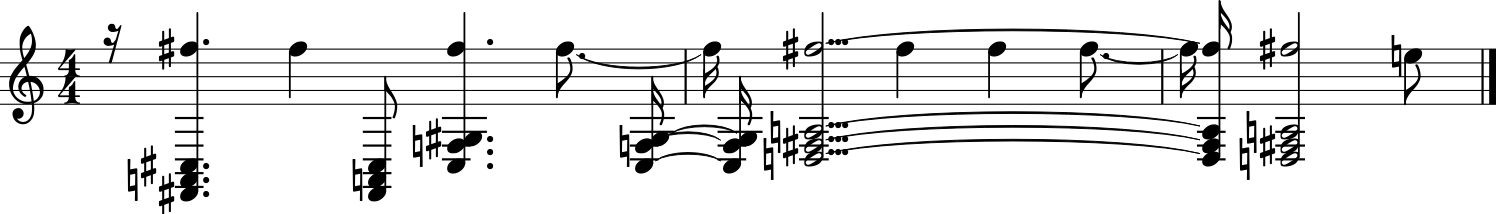

In [18]:
# Score
seed_stream.show()

**Full Sequence**

In [19]:
str2stream(' '.join(notes)).show('midi')

### Music Generation
Given the seed, we are predicting the next `n_words`.  
Temperature represents the amount of randomness. Higher = more random

In [20]:
# pred_out = seed + predictions 
pred_out = learn.predict(seed, n_words=300, temperature=1.5, min_p=0.05); pred_out

'|| t0 nF#2 t6 nA2 t6 nC#3 t6 nF#5 t4 || t3 nF#5 t4 || t1 nF#2 t2 nA2 t2 nC#3 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t4 || t3 nF#5 t4 || t1 nC#3 t2 nF3 t2 nG#3 t2 || t1 nD3 t16 nF#3 t16 nA3 t16 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t4 || t3 nD3 t8 nF#3 t8 nA3 t8 nF#5 t6 || t5 nE5 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t2 || t1 nG#5 t4 || t3 nC#3 t2 nF3 t2 nG#3 t2 nA5 t4 || t1 nB2 t16 nD3 t16 nF#3 t16 || t3 nF#5 t2 || t1 nA5 t4 || t3 nF#5 t4 || t3 nC#5 t2 || t1 nF#2 t6 nA2 t6 nC#3 t6 nF#5 t2 || t3 nF#5 t2 || t1 nF#2 t2 nA2 t2 nC#3 t2 nF#5 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t2 || t3 nF#5 t2 || t1 nC#3 t2 nF3 t2 nG#3 t2 nF#5 t2 || t1 nD3 t16 nF#3 t16 nA3 t16 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t2 || t3 nF#5 t4 || t3 nD3 t8 nF#3 t8 nA3 t8 nF#5 t2 || t3 nF#5 t4 || t3 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t4 || t3 nF#5 t2 || t1 nC#3 t2 nF3 t2 nG#3 t2 nG#5 t2 || t1 nB2 t16 nD3 t16 nF#3 t16 nA5 t4 || t3 nF#5 t2 || t1 nG#5 t2 || t1 nA5 t2 || t1 nG#5 t2 || t1 nF#5 t2 || t1 nC#5 t2 || t1 nF#2 t6 nA2 t6

In [21]:
# pred_only = predictions (without seed)
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t2 || t1 nG#5 t4 || t3 nC#3 t2 nF3 t2 nG#3 t2 nA5 t4 || t1 nB2 t16 nD3 t16 nF#3 t16 || t3 nF#5 t2 || t1 nA5 t4 || t3 nF#5 t4 || t3 nC#5 t2 || t1 nF#2 t6 nA2 t6 nC#3 t6 nF#5 t2 || t3 nF#5 t2 || t1 nF#2 t2 nA2 t2 nC#3 t2 nF#5 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t2 || t3 nF#5 t2 || t1 nC#3 t2 nF3 t2 nG#3 t2 nF#5 t2 || t1 nD3 t16 nF#3 t16 nA3 t16 nF#5 t4 || t3 nF#5 t4 || t3 nF#5 t2 || t3 nF#5 t4 || t3 nD3 t8 nF#3 t8 nA3 t8 nF#5 t2 || t3 nF#5 t4 || t3 nC#3 t6 nF3 t6 nG#3 t6 nF#5 t4 || t3 nF#5 t2 || t1 nC#3 t2 nF3 t2 nG#3 t2 nG#5 t2 || t1 nB2 t16 nD3 t16 nF#3 t16 nA5 t4 || t3 nF#5 t2 || t1 nG#5 t2 || t1 nA5 t2 || t1 nG#5 t2 || t1 nF#5 t2 || t1 nC#5 t2 || t1 nF#2 t6 nA2 t6 nC#3 t6 nC#5 t2 || t3 nC#5 t2 || t1 nF#2 t2 nA2 t2 nC#3 t2 nC#5 t2 || t1 nC#3 t6 nF3 t6 nG#3 t6 nC#5 t2 || t3 nC#5 t2 || t1 nC#3 t2 nF3 t2 nG#3 t2 nC#5 t2 || t1 nD3 t16 nF#3 t16 nA3 t16 nC#5 t2 || t1 nB4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nF#4 t2 || t3 nC#5 t4 || t3 nD3 t8 nF#3 t8 nA3 t8 

**Prediction only**

In [22]:
prediction_stream = str2stream(pred_only)
prediction_stream.show('midi')

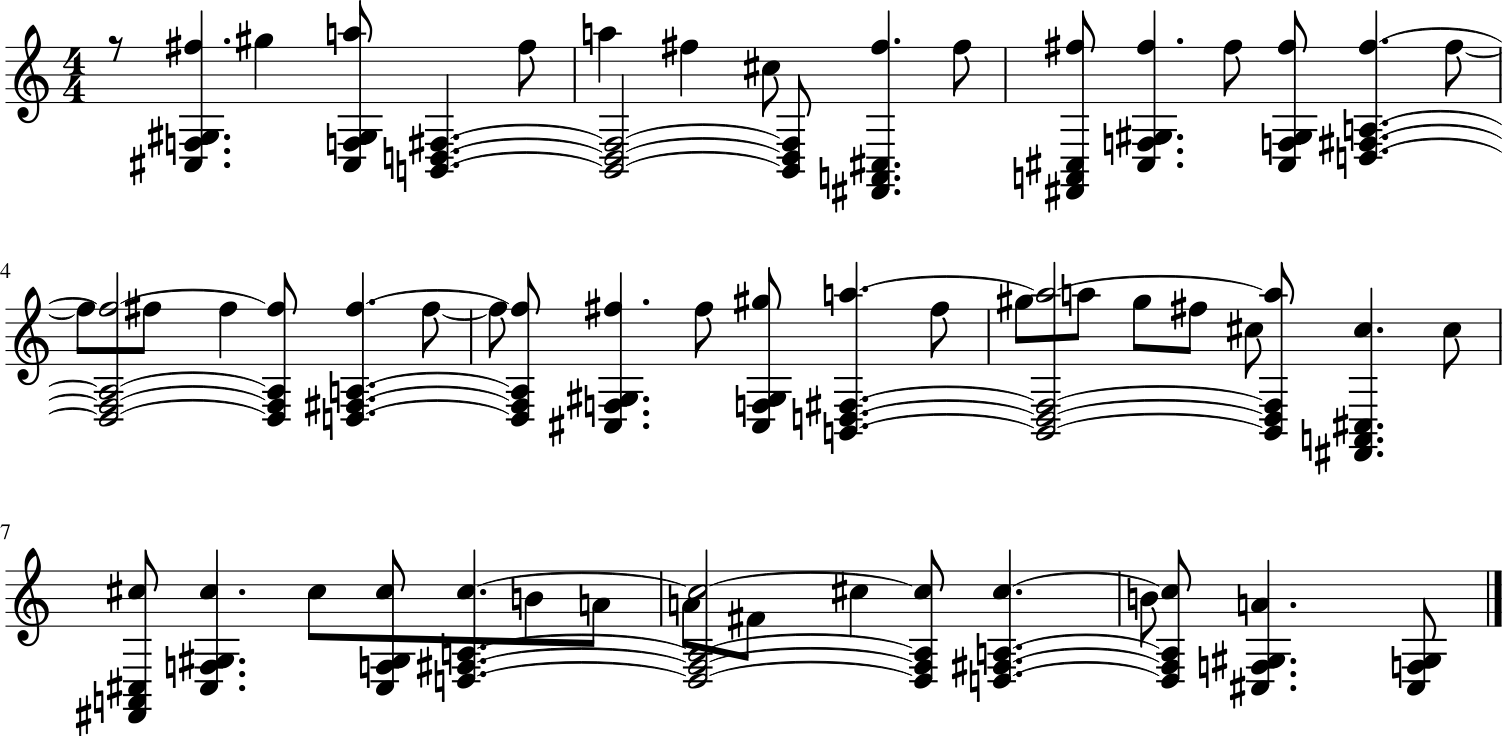

In [23]:
prediction_stream.show()

**Prediction with seed**  
Listen to the seed plus the predictions

In [24]:
full_stream = str2stream(pred_out)
full_stream.show('midi')

### Done. Repeat.
If you run the same `learn.predict` code again, you should get new predictions.  
Often, it takes a couple times to get a good output